# T026 · Kinase similarity: Interaction fingerprints

Authors:

- Talia B. Kimber, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)
- Andrea Volkamer, 2021, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

We will assess the similarity between a set of kinases based on the KLIFS interaction fingerprint (IFP), which describes the interactions seen in a structurally resolved kinase-ligand complex.  

### Contents in *Theory*

* Kinase dataset
* Kinase similarity descriptor: KLIFS interaction fingerprint
* Fetching KLIFS data with `opencadd.databases.klifs`

### Contents in *Practical*

* Retrieve and preprocess data
* Show kinase coverage
* Compare kinases
* Visualize similarity as kinase matrix
* Visualize similarity as phylogenetic tree

### References

* Kinase dataset: [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629) 
* Protein Data Bank
  - PDB URL: http://www.rcsb.org/
  - PDB database: [<i>Acta Cryst.</i> (2002), <b>D58</b>, 899-907](https://doi.org/10.1107/S0907444902003451) and [<i>Structure</i> (2012), <b>20(3)</b>, 391-396](https://doi.org/10.1016/j.str.2012.01.010)
* KLIFS
  - KLIFS URL: https://klifs.net/
  - KLIFS database: [<i>Nucleic Acid Res.</i> (2020), <b>49(D1)</b>, D562-D569](https://doi.org/10.1093/nar/gkaa895)
  - KLIFS binding site definition and interaction fingerprint calculation: [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w)
* Interaction fingerprint (IFP): [<i>J. Chem. Inf. Model.</i> (2007), <b>71(1)</b>, 195-207](https://doi.org/10.1021/ci600342e)
* `opencadd`, a Python library for structural cheminformatics
  - GitHub repository: https://github.com/volkamerlab/opencadd
  - Documentation: https://opencadd.readthedocs.io

## Theory

### Kinase dataset

We will use nine kinases from [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629), which aimed to understand kinase similarities within different combinations of kinase on- and off-targets (also called anti-targets):

> We aggregated the investigated kinases in “profiles” (Table 2). Profile 1 combined **EGFR** and **ErbB2** as targets (indicated by a ‘+’) and **BRAF** (from rapidly accelerated fibrosarcoma isoform B) as a (general) anti-target (designated by a ‘—’). Out of similar considerations, Profile 2 consisted of EGFR and **PI3K** as targets and BRAF as anti-target. This profile is expected to be more challenging as PI3K is an atypical kinase and thus less similar to EGFR than for example ErbB2 used in Profile 1. Profile 3, comprised of EGFR and **VEGFR2** as targets and BRAF as anti-target, was contrasted with the hit rate that we found with a standard docking against the single target VEGFR2 (Profile 4).
> To broaden the comparison and obtain an estimate for the promiscuity of each compound, the kinases **CDK2** (cyclic-dependent kinase 2), **LCK** (lymphocyte-specific protein tyrosine kinase), **MET** (mesenchymal-epithelial transition factor) and **p38α** (p38 mitogen activated protein kinase α) were included in the experimental assay panel and the structure-based bioinformatics comparison as commonly used anti-targets.

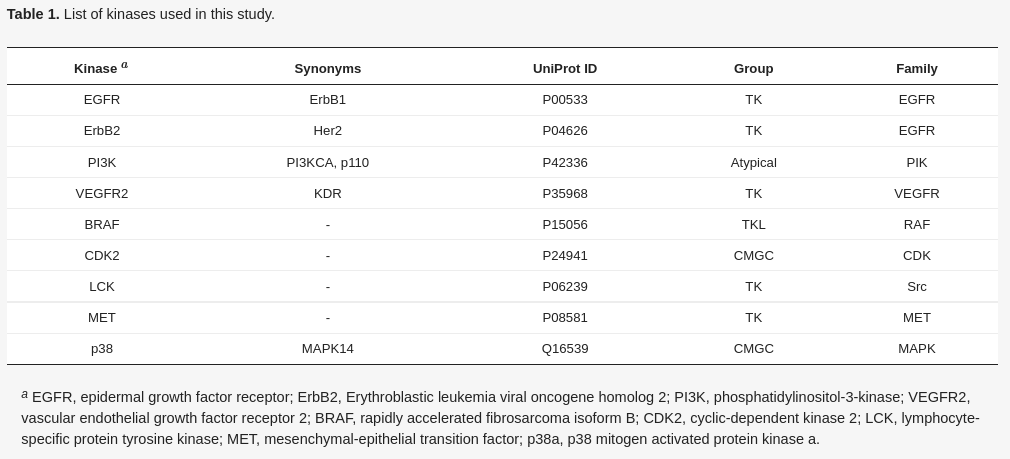

*Figure 1:* 
Kinases used in this notebook, taken from [<i>Molecules</i> (2021), <b>26(3)</b>, 629](https://www.mdpi.com/1420-3049/26/3/629) (Table 1).

### Kinase similarity descriptor: KLIFS interaction fingerprints

Interaction fingerprints encode the binding mode of a ligand in a binding site that is seen in a structurally resolved complex. If a ligand can form similar interaction patterns in proteins other (off-targets) than its designated protein (on-target), it is possible that this ligand will cause unintended side effects. Knowing about similarities between proteins can therefore help to avoid such off-target effects; or to exploit the found similarities for polypharmacology effects where one ligand intentially targets multiple proteins at once.

In this talktorial, we are interested in assessing the similarity between a set of kinases based on the similarity between their co-crystallized ligands' binding modes. We will make use of pre-calculated interaction fingerprints provided by the kinase-focused resource KLIFS.

The KLIFS database ([<i>Nucleic Acid Res.</i> (2020), <b>49(D1)</b>, D562-D569](https://doi.org/10.1093/nar/gkaa895), [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w)) fetches all kinase structures deposited in the structural database PDB ([<i>Acta Cryst.</i> (2002), <b>D58</b>, 899-907](https://doi.org/10.1107/S0907444902003451), [<i>Structure</i> (2012), <b>20(3)</b>, 391-396](https://doi.org/10.1016/j.str.2012.01.010)) and processes them as follows: All multi-chain structures in the PDB are split into monomers and aligned to each other with a special focus on a pre-defined binding site of 85 residues (Figure 1). For example, this means that the conserved gatekeeper (GK) residue at KLIFS position 45 can be easily and quickly looked up in any of the over 10,000 monomeric kinase structures in KLIFS. 

![KLIFS binding site](https://klifs.net/images/faq/xcolors.png.pagespeed.ic.dprMuoZGzn.webp)
*Figure 1:* 
Kinase binding site residues as defined by KLIFS.
Figure and description taken from: [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w).

The KLIFS authors calculate for each of these structures &mdash; that are co-crystallized with a ligand &mdash; an interaction fingerprint (IFP) as proposed by Marcou and Rognan ([<i>JCIM</i> (2007), <b>71(1)</b>, 195-207](https://pubs.acs.org/doi/10.1021/ci600342e)). This is how the IFP is described in the respective KLIFS pulication [<i>J. Med. Chem.</i> (2014), <b>57(2)</b>, 249-277](https://doi.org/10.1021/jm400378w):

> For each amino acid in the catalytic cleft, seven types of protein−ligand interactions are determined. The presence of a certain type of interaction results in the type-setting ofa “1” in the bit-string; otherwise a “0” is used to indicate the absence of the interaction. The following seven types of interactions are summarized in one bit-string; bit 1 = hydrophobic contact (HYD); bit 2 = face to face aromatic interactions (F−F); bit 3 = face to edge aromatic interactions (F−E); bit 4 = protein H-bond donor (DON); bit 5 = protein H- bond acceptor (ACC); bit 6 = protein cationic interactions (ION+), and bit 7 = protein anionic interactions (ION−).

This results in a $85 \times 7 = 595$ bit vector, which describes the interactions seen in a ligand-kinase complex. Since the binding site is aligned across all kinases, each bit position in this IFP can be directly compared across all IFPs in KLIFS. This is what we will do now in the practical part of this tutorial.

### Fetching KLIFS data with `opencadd.databases.klifs`

`opencadd` is a Python library for structural cheminformatics developed by the Volkamer lab at the Charité in Berlin. 
This library is a growing collection of modules that help facilitate and standardize common tasks in structural bioinformatics and cheminformatics. Today, we will use the module `opencadd.databases.klifs`, which allows us to fetch the KLIFS IFP as `pandas` DataFrame.

- GitHub repository: https://github.com/volkamerlab/opencadd
- Documentation: https://opencadd.readthedocs.io

For more information about this library and the KLIFS OpenAPI, please refer to __Talktorial T012__.

## Practical

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance_matrix, distance
from scipy.cluster import hierarchy
from opencadd.databases.klifs import setup_remote

INFO:opencadd.databases.klifs.api:If you want to see an non-truncated version of the DataFrames in this module, use `pd.set_option('display.max_columns', 50)` in your notebook.


In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Retrieve and preprocess data

Let's define our kinases of interest and all their synoyms as described in Table 1 in the global variable `query_kinases`.

In [3]:
query_kinases = [
    'EGFR', 
    'ErbB2', 'Her2',
    'PI3K', 'PI3KCA', 'p110a', 
    'BRAF', 
    'CDK2',
    'LCK', 
    'MET', 
    'p38a', 'MAPK14', 
    'VEGFR2', 'KDR'
]

Now, we query the KLIFS database using the `opencadd.databases.klifs` module to generate our IFP dataset.

In [4]:
from opencadd.databases.klifs import setup_remote

#### Set up a remote KLIFS session

In [5]:
klifs_session = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


#### Fetch all structures describing these kinases

In [6]:
structures = klifs_session.structures.by_kinase_name(kinase_names=query_kinases)
print(f"Number of structures: {len(structures)}")
print("Kinases:", *structures["kinase.klifs_name"].unique())

Number of structures: 2466
Kinases: CDK2 p38a EGFR ErbB2 MET LCK KDR BRAF p110a


#### Filter structures

We filter the structures by different criteria:

- Species: human
- Conformation: DFG-in
- Resolution: $\le 3$ Angström
- Quality score*: $\ge 6$

\* The KLIFS quality score takes into account the quality of the alignment and the number of missing residues and atoms (the higher the better the structure quality).

In [7]:
structures = structures[
    (structures["species.klifs"] == "Human")
    & (structures["structure.dfg"] == "in") 
    & (structures["structure.resolution"] <= 3) 
    & (structures["structure.qualityscore"] >= 6)
]
print(f"Number of structures: {len(structures)}")
print("Kinases:", *structures["kinase.klifs_name"].unique())

Number of structures: 1620
Kinases: CDK2 p38a EGFR ErbB2 MET LCK KDR BRAF p110a


Save the structure KLIFS IDs for the next step.

In [8]:
structure_klifs_ids = structures["structure.klifs_id"].to_list()

#### Fetch the structures' IFP (if available)

We fetch the IFPs for the set of structures. Not all structures will have an IFP because not all structures have a co-crystallized ligand.

In [9]:
ifps = klifs_session.interactions.by_structure_klifs_id(structure_klifs_ids)
print(f"Number of structures with IFPs: {len(ifps)}")
ifps.head()

Number of structures with IFPs: 1466


,structure.klifs_id,interaction.fingerprint
0,775,0000000000000010000000000000000000000000000000...
1,777,0000000000000010000001000000000000000000000000...
2,778,0000000000000010000000000000000000000000000000...
3,779,0000000000000010000001000000000000000000000000...
4,782,0000000000000010000001000000000000000000000000...


#### Merge structural and IFP data

In [10]:
structures = ifps.merge(structures, on="structure.klifs_id", how="inner")
print(f"Number of structures with IFPs: {len(structures)}")
structures.head()

Number of structures with IFPs: 1466


,structure.klifs_id,interaction.fingerprint,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,...,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,775,0000000000000010000000000000000000000000000000...,4r5s,-,A,Human,406,EGFR,<NA>,<NA>,...,False,False,False,False,False,False,21.684799,71.330002,42.087002,<NA>
1,777,0000000000000010000001000000000000000000000000...,3vjo,-,A,Human,406,EGFR,<NA>,<NA>,...,False,False,False,False,False,False,0.000000,0.000000,0.000000,<NA>
2,778,0000000000000010000000000000000000000000000000...,3w2s,A,A,Human,406,EGFR,<NA>,<NA>,...,False,False,False,False,False,False,16.591600,53.096100,37.676601,<NA>
3,779,0000000000000010000001000000000000000000000000...,2itu,A,A,Human,406,EGFR,<NA>,<NA>,...,False,False,False,False,False,False,20.174601,65.518700,21.431101,<NA>
4,782,0000000000000010000001000000000000000000000000...,3w33,A,A,Human,406,EGFR,<NA>,<NA>,...,False,False,False,False,False,False,14.820200,48.159698,43.046001,<NA>


### Show kinase coverage

Let's get the number of structures that describe our kinases (kinase coverage).

In [11]:
# Use pandas' groupby method to count the number of structures (rows) per kinase
n_structures_per_kinase = structures.groupby("kinase.klifs_name").size().sort_values()
n_structures_per_kinase

kinase.klifs_name
ErbB2      4
KDR        6
LCK       30
p110a     45
BRAF      57
MET       95
p38a     127
EGFR     339
CDK2     763
dtype: int64

Let's plot our results.

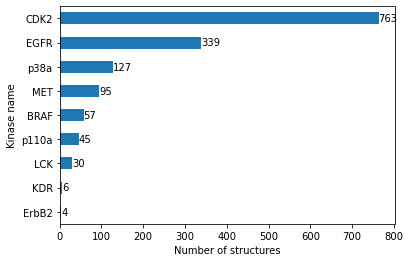

In [12]:
fig, ax = plt.subplots()
n_structures_per_kinase.plot(kind="barh", ax=ax)
ax.set_xlabel("Number of structures")
ax.set_ylabel("Kinase name")
for i, value in enumerate(n_structures_per_kinase):
    ax.text(value, i, str(value), va="center")

We see that our dataset is highly imbalanced. While some kinases are structurally resolved very often, other kinases are not: See e.g. CDK2 and EGFR vs. KDR and ErbB2. We will have to keep this in mind when interpreting our results later.

### Compare structures

We will compare the structures' IFP pairwise using the Tanimoto/Jaccard distance as implemented in `sklearn.metrics.pairwise_distances`, which uses under the hood the method `scipy.spatial.distance`.

#### 1. Prepare IFPs as `numpy` array

KLIFS deposits the IFP as a string of 0 and 1. We have to prepare our IFPs as an array of boolean vectors (required by `scipy.spatial.distance` to be able to use the Jaccard distance). Each row in this array refers to one IFP, each columns to one of the IFP's features.

In [13]:
# This is the KLIFS format of the IFP (structure KLIFS ID and kinase name set as index)
ifps = structures.set_index(["structure.klifs_id", "kinase.klifs_name"])["interaction.fingerprint"]
ifps.head()

structure.klifs_id  kinase.klifs_name
775                 EGFR                 0000000000000010000000000000000000000000000000...
777                 EGFR                 0000000000000010000001000000000000000000000000...
778                 EGFR                 0000000000000010000000000000000000000000000000...
779                 EGFR                 0000000000000010000001000000000000000000000000...
782                 EGFR                 0000000000000010000001000000000000000000000000...
Name: interaction.fingerprint, dtype: string

In [14]:
# Cast string to list of "0" and "1"
ifps = ifps.apply(list)
ifps.head()

structure.klifs_id  kinase.klifs_name
775                 EGFR                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
777                 EGFR                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
778                 EGFR                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
779                 EGFR                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
782                 EGFR                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
Name: interaction.fingerprint, dtype: object

In [15]:
# Cast "0" and "1" to boolean False and True
ifps = ifps.apply(lambda x: [True if i == "1" else False for i in x])
ifps.head()

structure.klifs_id  kinase.klifs_name
775                 EGFR                 [False, False, False, False, False, False, Fal...
777                 EGFR                 [False, False, False, False, False, False, Fal...
778                 EGFR                 [False, False, False, False, False, False, Fal...
779                 EGFR                 [False, False, False, False, False, False, Fal...
782                 EGFR                 [False, False, False, False, False, False, Fal...
Name: interaction.fingerprint, dtype: object

In [16]:
# Convert to numpy array
ifps_array = np.array(ifps.to_list())
ifps_array

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

#### Calculate pairwise Jaccard distances

In [17]:
structure_distance_matrix = pairwise_distances(ifps_array, metric="jaccard")
structure_distance_matrix

array([[0.        , 0.72      , 0.54285714, ..., 0.40740741, 0.73333333,
        0.73333333],
       [0.72      , 0.        , 0.74193548, ..., 0.70833333, 0.76190476,
        0.76190476],
       [0.54285714, 0.74193548, 0.        , ..., 0.61111111, 0.78378378,
        0.78378378],
       ...,
       [0.40740741, 0.70833333, 0.61111111, ..., 0.        , 0.57692308,
        0.57692308],
       [0.73333333, 0.76190476, 0.78378378, ..., 0.57692308, 0.        ,
        0.        ],
       [0.73333333, 0.76190476, 0.78378378, ..., 0.57692308, 0.        ,
        0.        ]])

In [18]:
# Create DataFrame with structure KLIFS IDs as index/columns
structure_klifs_ids = ifps.index.get_level_values(0)
structure_distance_matrix = pd.DataFrame(
    structure_distance_matrix, index=structure_klifs_ids, columns=structure_klifs_ids
)
print(f"Structure distance matrix size: {structure_distance_matrix.shape}")
print("Show matrix subset:")
structure_distance_matrix.iloc[:5, :5]

Structure distance matrix size: (1466, 1466)
Show matrix subset:


structure.klifs_id,775,777,778,779,782
structure.klifs_id,,,,,
775,0.000000,0.720000,0.542857,0.500000,0.483871
777,0.720000,0.000000,0.741935,0.500000,0.703704
778,0.542857,0.741935,0.000000,0.696970,0.411765
779,0.500000,0.500000,0.696970,0.000000,0.655172
782,0.483871,0.703704,0.411765,0.655172,0.000000


### Map structure to kinase distance matrix

First &mdash; as an intermediate step &mdash; we will create a structure distance matrix but instead of labeling the data with structure KLIFS IDs we add the corresponding kinase name.

In [19]:
# Copy distance matrix to kinase matrix
kinase_distance_matrix = structure_distance_matrix
# Replace structure KLIFS IDs with the structures' kinase names
kinase_names = ifps.index.get_level_values(1)
kinase_distance_matrix.index = kinase_names
kinase_distance_matrix.columns = kinase_names
print("Show matrix subset:")
kinase_distance_matrix.iloc[:5, :5]

Show matrix subset:


kinase.klifs_name,EGFR,EGFR,EGFR,EGFR,EGFR
kinase.klifs_name,,,,,
EGFR,0.000000,0.720000,0.542857,0.500000,0.483871
EGFR,0.720000,0.000000,0.741935,0.500000,0.703704
EGFR,0.542857,0.741935,0.000000,0.696970,0.411765
EGFR,0.500000,0.500000,0.696970,0.000000,0.655172
EGFR,0.483871,0.703704,0.411765,0.655172,0.000000


A kinase pair can be representated by many different structure pairs which are associated with different distance values. For example, if we compare all EGFR structure to each other, the range of distance values is already quite high because we can observe quite different binding modes of the co-crystallized ligands.

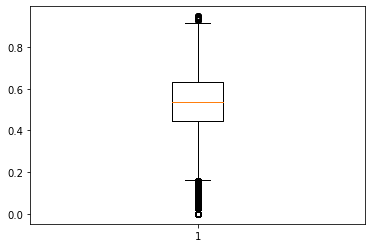

In [20]:
# Select EGFR-EGFR strcture pairs only
D = kinase_distance_matrix.loc["EGFR", "EGFR"]
# Extract all pairwise distances without identical structure pairs 
# = lower triangular matrix without the diagonal
D_condensed = distance.squareform(D)
# Plot pairwise distances
plt.boxplot(D_condensed);

In this talktorial, we will consider per kinase pair the two structures that show the most similar binding mode for their co-crystallized ligands. Hence, we select the structure pair with the minimum distance as representative for a kinase pair.

In [21]:
# We unstack the matrix (each pairwise comparison in a single row)
# We group by kinase names (level=[0, 1] ensures that the order of the kinases is ignored
# We take the minimum value in each kinase pair group
# We unstack the remaining data points
kinase_distance_matrix = kinase_distance_matrix.unstack().groupby(level=[0, 1]).min().unstack(level=1)
kinase_distance_matrix

kinase.klifs_name,BRAF,CDK2,EGFR,ErbB2,KDR,LCK,MET,p110a,p38a
kinase.klifs_name,,,,,,,,,
BRAF,0.000000,0.300000,0.277778,0.393939,0.363636,0.320000,0.368421,0.500000,0.333333
CDK2,0.300000,0.000000,0.111111,0.451613,0.238095,0.190476,0.133333,0.347826,0.277778
EGFR,0.277778,0.111111,0.000000,0.258065,0.238095,0.166667,0.227273,0.380952,0.173913
ErbB2,0.393939,0.451613,0.258065,0.000000,0.406250,0.419355,0.382353,0.571429,0.258065
KDR,0.363636,0.238095,0.238095,0.406250,0.000000,0.058824,0.333333,0.533333,0.043478
LCK,0.320000,0.190476,0.166667,0.419355,0.058824,0.000000,0.250000,0.375000,0.190476
MET,0.368421,0.133333,0.227273,0.382353,0.333333,0.250000,0.000000,0.428571,0.352941
p110a,0.500000,0.347826,0.380952,0.571429,0.533333,0.375000,0.428571,0.000000,0.473684
p38a,0.333333,0.277778,0.173913,0.258065,0.043478,0.190476,0.352941,0.473684,0.000000


### Visualize similarity as kinase matrix

We visualize the kinase matrix in the form of a heatmap.

NameError: name 'kinase_similarity_matrix' is not defined

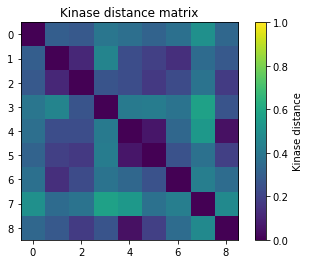

In [22]:
plt.imshow(kinase_distance_matrix, vmin=0.0, vmax=1.0)
plt.colorbar(label="Kinase distance")
plt.title("Kinase distance matrix")
kinase_names = kinase_similarity_matrix.columns.to_list()
plt.xticks(ticks=range(0, len(kinase_names)), labels=kinase_names, rotation=45);
plt.yticks(ticks=range(0, len(kinase_names)), labels=kinase_names);

We have calculated distances between fingerprints that range from 0 to 1 (identical to dissimilar). The term similarity is often defined between 0 and 1 (dissimilar to identical), hence for the following heatmap, we will use the transformation $similarity = 1 - distance$.

In [ ]:
kinase_similarity_matrix = 1 - kinase_distance_matrix
plt.imshow(kinase_similarity_matrix, vmin=0.0, vmax=1.0)
plt.colorbar(label="Kinase similarity")
plt.title("Kinase distance matrix")
kinase_names = kinase_similarity_matrix.columns.to_list()
plt.xticks(ticks=range(0, len(kinase_names)), labels=kinase_names, rotation=45);
plt.yticks(ticks=range(0, len(kinase_names)), labels=kinase_names);

### Visualize similarity as dendrogram

We use the `scipy` function `squareform` to create a condensed vector of the distance matrix of shape $n*(n-1)/2$, where $n$ is the shape of the quadratic distance matrix. The values in this vector correspond to the values of the lower triangular matrix.

In [ ]:
D = kinase_distance_matrix.to_numpy()
D_condensed = distance.squareform(D)
D_condensed

We can submit this condensed vector to a hierarchical clustering to extract the relationship between the different kinases. We use here `method="average"`, which stands for the linkage method UPGMA (unweighted pair group method with arithmetic mean). This means that the distance between two clusters A and B is defined as the avarge of all distances between pairs of elements in clusters A and B. At each clustering step, the two clusters with the lowest average distance are combined.

In [ ]:
hclust = hierarchy.linkage(D_condensed, method="average")

We now generate a phylogenetic tree based on our clustering.

In [ ]:
tree = hierarchy.to_tree(hclust)

We visualize this tree as dendrogram.

In [ ]:
fig, ax = plt.subplots()
labels = kinase_distance_matrix.columns.to_list()
hierarchy.dendrogram(hclust, labels=labels, orientation="left", ax=ax)
ax.set_xlabel("Distance");

## Discussion

In this talktorial, we have used the KLIFS interaction fingerprints, which describe binding modes of co-crystallized ligands in kinase structures, to assess kinase similarity. 

## Quiz

1. Why is the structural coverage between kinases so different?
2. At one point, we are mapping structure pairs to kinase pairs. We use here the minimum structure distance. What other mapping strategies can you think of? What advantages and disadvantages could they have?
3. What is the difference between the distances that we show in the heatmap and the dendrogram? 